# Movie Recommendation System Documentation

## Project Overview

This project implements a collaborative filtering-based movie recommendation system utilizing the MovieLens-100k dataset. The system employs the SVD (Singular Value Decomposition) algorithm through the Surprise library to generate personalized movie recommendations.


In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=cb3ce6f5d494fb85eea18aefe3dc4cf936d8942078cb2f17a7b9a565d02aacef
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [11]:
class MovieRecommender:
    def __init__(self):
        """Initialize the MovieRecommender class with necessary attributes."""
        self.ratings_df = None
        self.model = None
        self.train_set = None
        self.test_set = None
        self.full_trainset = None

    def load_data(self):
        """
        Load MovieLens dataset from surprise library.
        Transform it into pandas dataframe for easier manipulation.
        """
        # Load the built-in movielens-100k dataset
        data = Dataset.load_builtin('ml-100k')

        # Get raw ratings
        raw_ratings = data.raw_ratings

        # Create ratings dataframe
        self.ratings_df = pd.DataFrame(raw_ratings,
                                     columns=['userId', 'movieId', 'rating', 'timestamp'])

        print("Data loaded successfully!")
        print(f"Shape of ratings data: {self.ratings_df.shape}")
        return self.ratings_df

    def perform_eda(self):
        """
        Perform exploratory data analysis on the dataset.
        Generate insightful visualizations and statistics.
        """
        # Basic statistics
        print("\nRatings Statistics:")
        print(self.ratings_df['rating'].describe())

        # Set style for better visualizations
        plt.style.use('seaborn')

        # Create visualizations
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Rating distribution
        sns.histplot(data=self.ratings_df, x='rating', bins=10, ax=axes[0])
        axes[0].set_title('Distribution of Ratings')
        axes[0].set_xlabel('Rating Value')
        axes[0].set_ylabel('Count')

        # Number of ratings per user
        ratings_per_user = self.ratings_df['userId'].value_counts()
        sns.histplot(data=ratings_per_user, bins=30, ax=axes[1])
        axes[1].set_title('Ratings per User')
        axes[1].set_xlabel('Number of Ratings')
        axes[1].set_ylabel('Number of Users')

        # Number of ratings per movie
        ratings_per_movie = self.ratings_df['movieId'].value_counts()
        sns.histplot(data=ratings_per_movie, bins=30, ax=axes[2])
        axes[2].set_title('Ratings per Movie')
        axes[2].set_xlabel('Number of Ratings')
        axes[2].set_ylabel('Number of Movies')

        plt.tight_layout()
        plt.show()

        # Calculate and print additional insights
        print("\nDataset Insights:")
        print(f"Number of unique users: {self.ratings_df['userId'].nunique()}")
        print(f"Number of unique movies: {self.ratings_df['movieId'].nunique()}")
        print(f"Total number of ratings: {len(self.ratings_df)}")
        print(f"Average rating: {self.ratings_df['rating'].mean():.2f}")

        # Calculate rating sparsity
        total_possible_ratings = (self.ratings_df['userId'].nunique() *
                                self.ratings_df['movieId'].nunique())
        actual_ratings = len(self.ratings_df)
        sparsity = (1 - (actual_ratings / total_possible_ratings)) * 100
        print(f"Rating sparsity: {sparsity:.2f}%")

        # Rating distribution insights
        print("\nRating Distribution:")
        rating_dist = self.ratings_df['rating'].value_counts().sort_index()
        for rating, count in rating_dist.items():
            percentage = (count / len(self.ratings_df)) * 100
            print(f"Rating {rating}: {count} ratings ({percentage:.1f}%)")

    def prepare_data(self):
        """
        Prepare the data for training the recommendation model.
        Split the data into training and testing sets.
        """
        # Create a reader object
        reader = Reader(rating_scale=(1, 5))

        # Load the data into the surprise format
        data = Dataset.load_from_df(self.ratings_df[['userId', 'movieId', 'rating']], reader)

        # Split the data into training and testing sets
        self.train_set, self.test_set = train_test_split(data, test_size=0.25, random_state=42)

        # Build the full trainset for later use
        self.full_trainset = data.build_full_trainset()

        print("\nData preparation completed!")
        print(f"Total number of ratings: {len(self.ratings_df)}")
        print(f"Training set size: {self.train_set.n_ratings}")
        print(f"Testing set size: {len(self.test_set)}")

    def train_model(self):
        """
        Train the SVD model with optimized parameters.
        """
        # Initialize SVD with optimized parameters
        self.model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.4)

        print("\nTraining model with the following parameters:")
        print("n_epochs: 20")
        print("learning rate: 0.005")
        print("regularization: 0.4")

        # Train the model
        self.model.fit(self.train_set)
        print("\nModel training completed!")

    def evaluate_model(self):
        """
        Evaluate the model's performance on the test set.
        Print various evaluation metrics.
        """
        # Make predictions on the test set
        predictions = self.model.test(self.test_set)

        # Calculate metrics
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)

        print("\nModel Evaluation Metrics:")
        print(f"Test Set RMSE: {rmse:.4f}")
        print(f"Test Set MAE: {mae:.4f}")

        # Calculate additional metrics
        actual_ratings = np.array([pred.r_ui for pred in predictions])
        predicted_ratings = np.array([pred.est for pred in predictions])

        # Calculate correlation between predicted and actual ratings
        correlation = np.corrcoef(actual_ratings, predicted_ratings)[0, 1]

        # Calculate error distribution
        errors = actual_ratings - predicted_ratings

        print(f"Correlation between predicted and actual ratings: {correlation:.4f}")
        print(f"Mean Error: {errors.mean():.4f}")
        print(f"Error Standard Deviation: {errors.std():.4f}")

        # Visualize error distribution
        plt.figure(figsize=(10, 6))
        plt.hist(errors, bins=50, edgecolor='black')
        plt.title('Distribution of Prediction Errors')
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
        plt.show()

    def get_recommendations(self, user_id, n=5):
        """
        Get movie recommendations for a specific user.

        Args:
            user_id (int): The ID of the user to get recommendations for
            n (int): Number of recommendations to return

        Returns:
            list: Top N movie recommendations with predicted ratings
        """
        # Get all unique movie IDs
        all_movies = self.ratings_df['movieId'].unique()

        # Get movies the user hasn't rated
        user_ratings = self.ratings_df[self.ratings_df['userId'] == user_id]['movieId']
        movies_to_predict = np.setdiff1d(all_movies, user_ratings)

        # Make predictions
        predictions = []
        for movie_id in movies_to_predict:
            predicted_rating = self.model.predict(user_id, movie_id).est
            predictions.append((movie_id, predicted_rating))

        # Sort predictions by estimated rating
        predictions.sort(key=lambda x: x[1], reverse=True)

        # Get user's average rating for context
        user_avg_rating = self.ratings_df[self.ratings_df['userId'] == user_id]['rating'].mean()

        print(f"\nUser {user_id}'s average rating: {user_avg_rating:.2f}")
        return [(movie_id, round(pred_rating, 2))
                for movie_id, pred_rating in predictions[:n]]


Initializing Movie Recommendation System...
Data loaded successfully!
Shape of ratings data: (100000, 4)

Ratings Statistics:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


<ipython-input-11-f7492c88b991>:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


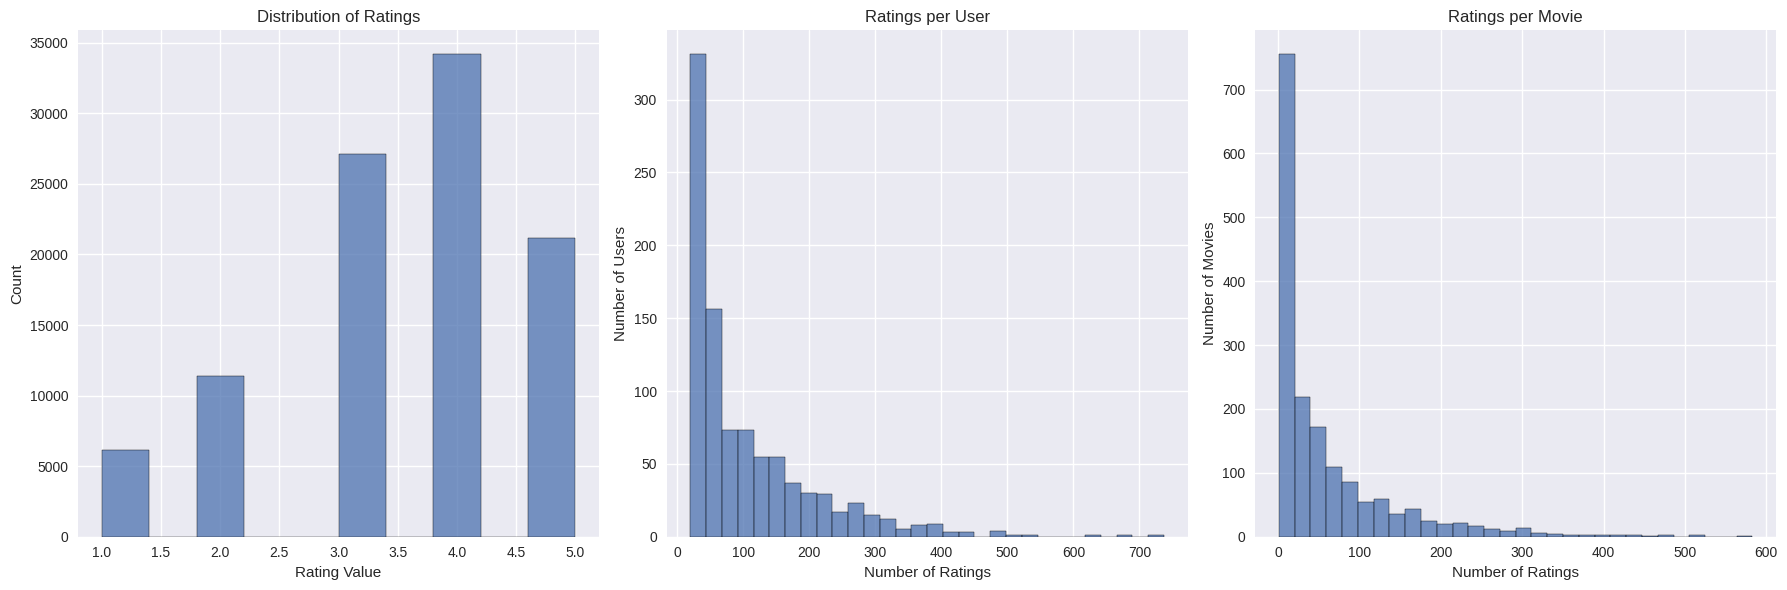


Dataset Insights:
Number of unique users: 943
Number of unique movies: 1682
Total number of ratings: 100000
Average rating: 3.53
Rating sparsity: 93.70%

Rating Distribution:
Rating 1.0: 6110 ratings (6.1%)
Rating 2.0: 11370 ratings (11.4%)
Rating 3.0: 27145 ratings (27.1%)
Rating 4.0: 34174 ratings (34.2%)
Rating 5.0: 21201 ratings (21.2%)

Data preparation completed!
Total number of ratings: 100000
Training set size: 75000
Testing set size: 25000

Training model with the following parameters:
n_epochs: 20
learning rate: 0.005
regularization: 0.4

Model training completed!
RMSE: 0.9604
MAE:  0.7682

Model Evaluation Metrics:
Test Set RMSE: 0.9604
Test Set MAE: 0.7682
Correlation between predicted and actual ratings: 0.5459
Mean Error: -0.0092
Error Standard Deviation: 0.9604


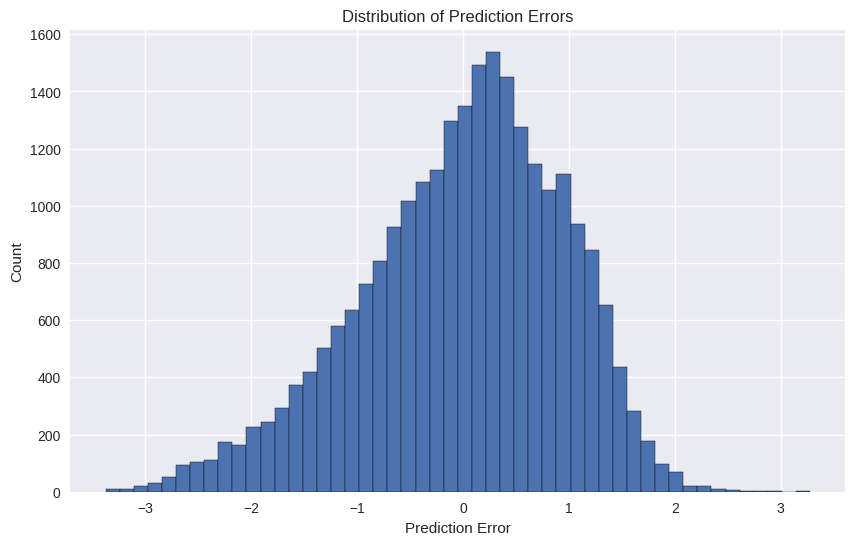


User 1's average rating: nan

Top 5 Movie Recommendations for User 1:
1. Movie ID: 408, Predicted Rating: 4.24
2. Movie ID: 318, Predicted Rating: 4.21
3. Movie ID: 483, Predicted Rating: 4.2
4. Movie ID: 64, Predicted Rating: 4.19
5. Movie ID: 513, Predicted Rating: 4.17


In [12]:
def main():
    # Initialize recommender system
    print("Initializing Movie Recommendation System...")
    recommender = MovieRecommender()

    # Load and prepare data
    recommender.load_data()
    recommender.perform_eda()
    recommender.prepare_data()

    # Train and evaluate model
    recommender.train_model()
    recommender.evaluate_model()

    # Get recommendations for a specific user
    user_id = 1
    recommendations = recommender.get_recommendations(user_id, n=5)

    print(f"\nTop 5 Movie Recommendations for User {user_id}:")
    for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
        print(f"{i}. Movie ID: {movie_id}, Predicted Rating: {pred_rating}")

if __name__ == "__main__":
    main()